# Richter's Nepal Earthquake

In [1]:
#Importing the Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", context="notebook", palette="deep", color_codes=True)

from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

c:\users\debad\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Importing the Data
train = pd.read_csv(r'...\train_values.csv')
trainy = pd.read_csv(r'...\train_labels.csv')

train = train.join(trainy['damage_grade'])
train.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,3


In [3]:
train = train.fillna(np.nan)
train.isnull().sum()

building_id                               0
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo       

In [4]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers
Outliers_to_drop = detect_outliers(train,2,["count_floors_pre_eq", "age", "area_percentage", "height_percentage", "count_families"])

In [5]:
train.loc[Outliers_to_drop]

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
29,529366,27,548,1119,3,60,27,10,t,r,...,0,0,0,0,0,0,0,0,0,3
42,833827,17,1030,1525,3,70,16,7,t,r,...,0,0,0,0,0,0,0,0,0,3
170,964939,27,1155,11652,3,15,16,8,t,r,...,0,0,0,0,0,0,0,0,0,2
216,612661,11,883,2822,5,100,12,11,t,r,...,0,0,0,0,0,0,0,0,0,2
276,233499,21,363,7868,3,10,11,10,t,i,...,1,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200106,489052,26,1081,11012,2,40,21,10,t,r,...,0,0,0,0,0,0,0,0,0,2
205702,618928,17,1279,2597,2,45,20,10,n,r,...,0,0,0,0,0,0,0,0,0,2
222110,91061,26,1081,11012,2,40,16,10,t,r,...,1,0,0,0,0,0,0,0,0,1
238146,674223,20,158,2452,2,5,30,10,t,u,...,0,0,0,0,0,0,0,0,0,2


In [6]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

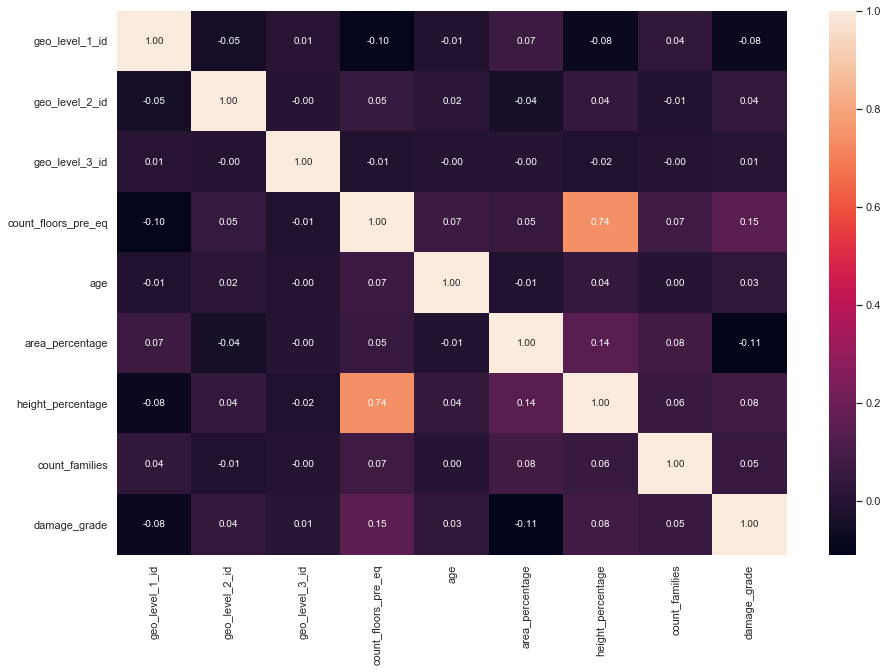

In [7]:
plt.figure(figsize=(15,10))
c = sns.heatmap(train[["geo_level_1_id","geo_level_2_id", "geo_level_3_id", "count_floors_pre_eq", "age", "area_percentage", "height_percentage", 
                       "count_families", "damage_grade"]].corr(), annot=True, fmt="0.2f")

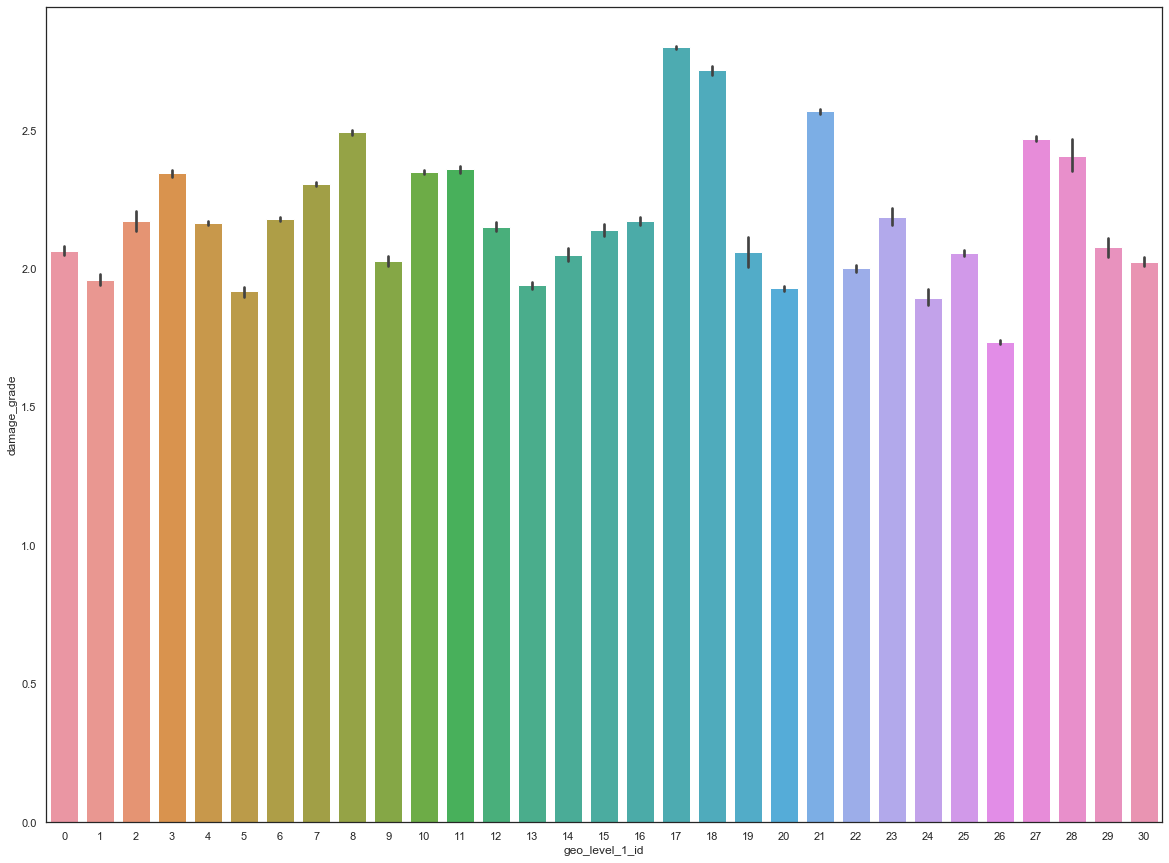

In [8]:
plt.figure(figsize=(20,15))
sns.barplot(train['geo_level_1_id'], train['damage_grade'])

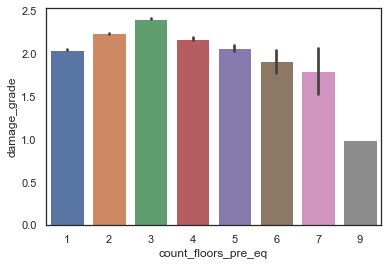

In [9]:
sns.barplot(train['count_floors_pre_eq'], train['damage_grade'])

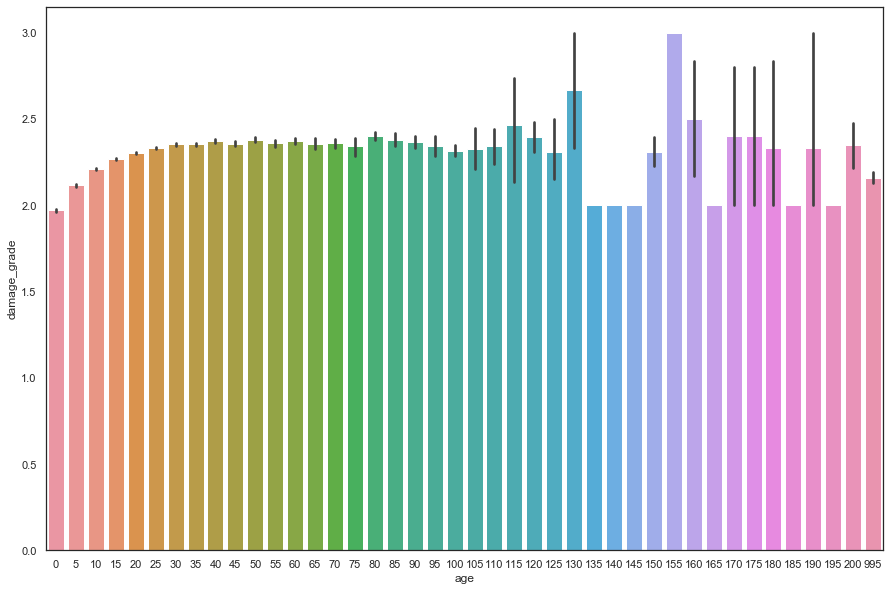

In [10]:
plt.figure(figsize=(15,10))
sns.barplot(train['age'], train['damage_grade'])

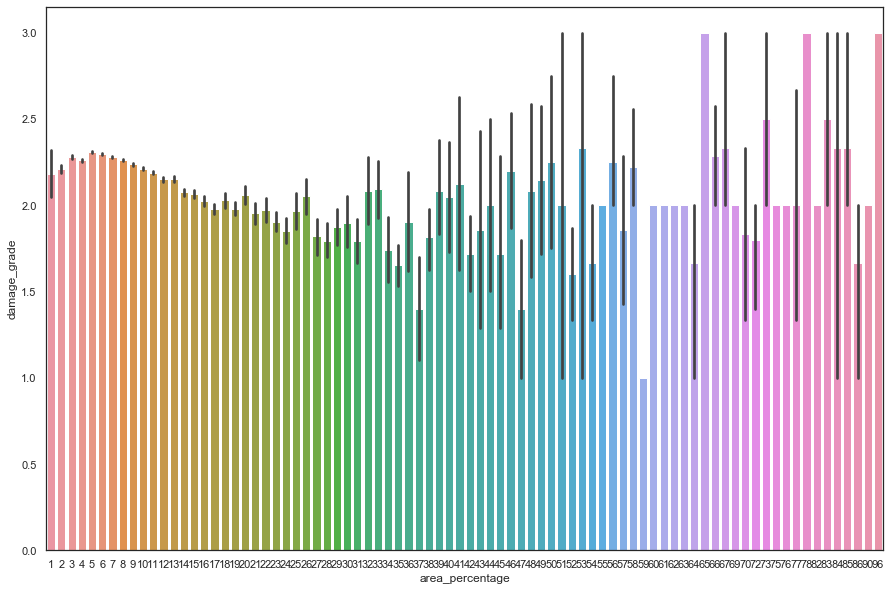

In [11]:
plt.figure(figsize=(15,10))
sns.barplot(train['area_percentage'], train['damage_grade'])

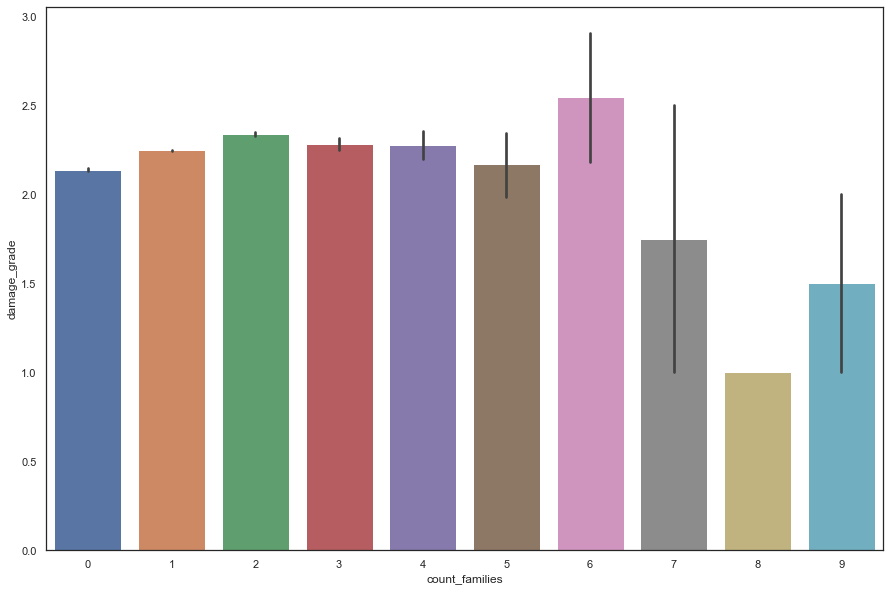

In [12]:
plt.figure(figsize=(15,10))
sns.barplot(train['count_families'], train['damage_grade'])

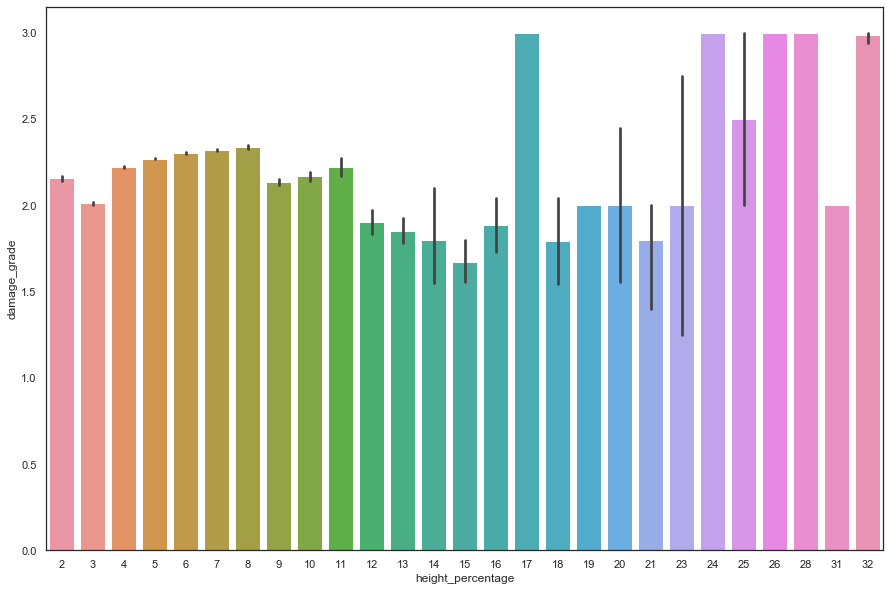

In [13]:
plt.figure(figsize=(15,10))
sns.barplot(train['height_percentage'], train['damage_grade'])

In [14]:
trainy = train['damage_grade']
trainy.shape

(254104,)

In [15]:
# train = train.drop("damage_grade", axis=1)
dataset = train.append(test, ignore_index = True) 

In [16]:
dataset = dataset.drop(["geo_level_2_id", "geo_level_3_id"], axis=1)

## Feature Engineering

In [17]:
dataset['lowHeight'] = dataset['height_percentage'].map(lambda s: 1 if s <= 11 else 0)
dataset['medHeight'] = dataset['height_percentage'].map(lambda s: 1 if 12 <= s <= 23 else 0)
dataset['highHeight'] = dataset['height_percentage'].map(lambda s: 1 if 24 <= s else 0)

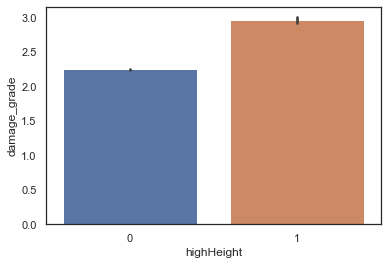

In [18]:
sns.barplot("highHeight", "damage_grade", data=dataset)

In [19]:
dataset['lessFloors'] = dataset['count_floors_pre_eq'].map(lambda s: 1 if s <= 5 else 0)
dataset['lotFloors'] = dataset['count_floors_pre_eq'].map(lambda s: 1 if s >= 6 else 0)

In [20]:
train.shape

(254104, 40)

In [21]:
dataset = pd.get_dummies(dataset, columns = ["land_surface_condition"], prefix="LSC")
dataset = pd.get_dummies(dataset, columns = ["foundation_type"], prefix="FT")
dataset = pd.get_dummies(dataset, columns = ["roof_type"], prefix="RT")
dataset = pd.get_dummies(dataset, columns = ["ground_floor_type"], prefix="GFT")
dataset = pd.get_dummies(dataset, columns = ["other_floor_type"], prefix="OFT")
dataset = pd.get_dummies(dataset, columns = ["position"], prefix="P")
dataset = pd.get_dummies(dataset, columns = ["plan_configuration"], prefix="PC")
dataset = pd.get_dummies(dataset, columns = ["legal_ownership_status"], prefix="LOS")

In [22]:
X_train = dataset[:254104]
X_test = dataset[254104:]

In [23]:
X_train = X_train.drop(["building_id", "damage_grade"], axis=1)
X_test = X_test.drop(["building_id", "damage_grade"], axis=1)

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
pca = PCA(n_components=71)
pca.fit(X_train)
print(pca.explained_variance_ratio_.cumsum())

[0.08285566 0.13262575 0.16743514 0.19870082 0.22888569 0.25724676
 0.28519609 0.31150819 0.33585971 0.35922807 0.38217208 0.40325357
 0.42387745 0.44316352 0.46151457 0.47834331 0.49402699 0.50928851
 0.52415572 0.53898433 0.5536498  0.56814025 0.58255666 0.59692063
 0.611184   0.6254365  0.63964052 0.65381165 0.66793899 0.68203594
 0.69612727 0.71020019 0.72424137 0.73828226 0.75224186 0.76617961
 0.78006011 0.79386781 0.80758451 0.82109896 0.83459459 0.8479687
 0.86121545 0.87404169 0.88669274 0.89899334 0.9112132  0.92284934
 0.93348451 0.94351402 0.95277932 0.96114524 0.96873698 0.97555015
 0.98083047 0.98588216 0.9900735  0.99369276 0.99729019 0.99991292
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.        ]


In [26]:
pca_fin = PCA(n_components=55)
X_train = pca_fin.fit_transform(X_train)
X_test = pca_fin.transform(X_test)

In [27]:
y_train = trainy.iloc[:].values
y_train

array([3, 2, 3, ..., 3, 2, 3], dtype=int64)

In [28]:
X_train_split , X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [29]:
classifier = RandomForestClassifier(n_estimators=300, n_jobs=4)
classifier.fit(X_train_split,y_train_split)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [171]:
y_pred = classifier.predict(X_test_split)

In [176]:
print(accuracy_score(y_test_split, y_pred))

0.9178095669113162


In [177]:
print(confusion_matrix(y_test_split, y_pred))

[[ 4173   525    53]
 [  193 27437  1336]
 [   45  2025 15034]]


In [182]:
print(f1_score(y_test_split, y_pred, average='micro'))

0.9178095669113162
